<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Gaussian-Mixture-Model" data-toc-modified-id="Gaussian-Mixture-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Gaussian Mixture Model</a></span><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#n_components-=-2" data-toc-modified-id="n_components-=-2-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>n_components = 2</a></span></li><li><span><a href="#Best-n_components" data-toc-modified-id="Best-n_components-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Best n_components</a></span></li></ul></li></ul></div>

# Gaussian Mixture Model

In [14]:
!pip -q install gitpython
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import git
import shutil

In [15]:
def RGB_seperator(image_directory):
  image_set = pd.DataFrame()
  image_files = os.listdir(image_directory)
  labels = []
  for image_file in image_files:
    # Load the image using OpenCV
    image_path = os.path.join(image_directory, image_file)
    image = cv2.imread(image_path)
    labels.append(os.path.basename(image_path).split('.')[0])
    # Split the image into R&B channels
    blue_channel = np.mean(image[:, :, 0])
    red_channel = np.mean(image[:, :, 2])

    # Create a temporary dataframe for the current image
    image_df = pd.DataFrame({'Blue': [blue_channel], 'Red': [red_channel]})
    image_set = pd.concat([image_df, image_set])

  image_set['label'] = labels
  image_set = image_set.reset_index(drop=True)
  return image_set

In [ ]:
# if os.path.exists(local_directory):
#     shutil.rmtree(local_directory)

In [16]:
github_repo_url = 'https://github.com/fardinabbasi/Expectation_Maximization.git'
local_directory = '/content/Expectation_Maximization'
git.Repo.clone_from(github_repo_url, local_directory)

<git.repo.base.Repo '/content/Expectation_Maximization/.git'>

In [17]:
image_directory = os.path.join(local_directory, 'Images')
image_set = RGB_seperator(image_directory)
features = image_set[['Red','Blue']]
labels = image_set[['label']]
labels

,label
0,c8
1,m2
2,m34
3,c14
4,c30
...,...
117,c18
118,m3
119,m9
120,m33


## Preprocessing

In [18]:
!pip install -q fuzzywuzzy
from fuzzywuzzy import fuzz, process
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [19]:
def fix_label(df):
  df_copy = df.copy()
  valid_values = ['c', 'm']
  df_copy['label'].replace(['ManUtd-508878051576073641743_medium', '1', 'images'], 'm', inplace=True)
  df_copy['label'].replace('index', 'c', inplace=True)
  df_copy['label'] = df_copy['label'].apply(lambda x: process.extractOne(x.lower(), valid_values, scorer=fuzz.token_set_ratio)[0])
  return df_copy

label
c        64
m        58
dtype: int64


,Red,Blue
count,122.000000,122.000000
mean,91.975741,78.674581
std,29.686593,30.071529
min,36.829846,23.841212
25%,70.142986,55.459667
50%,90.938226,72.883534
75%,109.730649,96.326040
max,171.014902,188.230243


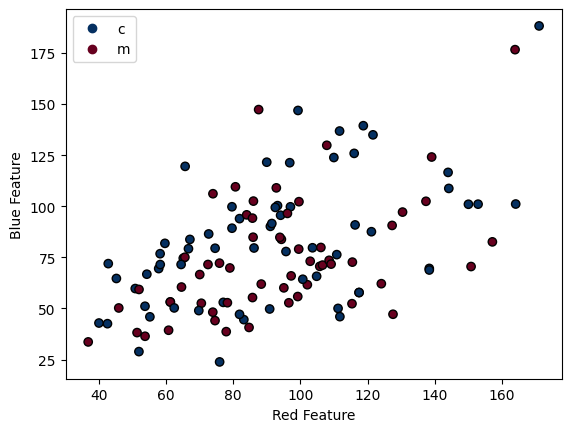

In [20]:
labels = fix_label(labels)
print(labels.value_counts())

#features = pd.DataFrame(StandardScaler().fit_transform(features),columns=features.columns)
display(features.describe())

labels_code = labels.astype("category").apply(lambda x: x.cat.codes).to_numpy()
scatter = plt.scatter(features['Red'], features['Blue'], c=labels_code,cmap='RdBu_r', edgecolors='k',)
plt.xlabel('Red Feature')
plt.ylabel('Blue Feature')
plt.legend(handles=scatter.legend_elements()[0], labels=['c','m'])
plt.show()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

## n_components = 2

In [21]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

In [22]:
gmm = GaussianMixture(n_components = 2, random_state=123)
gmm.fit(X_train.values)
print("Means:\n",gmm.means_)
print("Covariances:\n",gmm.covariances_)

Means:
 [[ 62.90463389  55.94726292]
 [104.2721353   86.41319827]]
Covariances:
 [[[209.36227206  42.49085004]
  [ 42.49085004 214.85537558]]

 [[716.86090511 177.62053205]
  [177.62053205 792.93296736]]]


In [23]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle=angle, **kwargs))

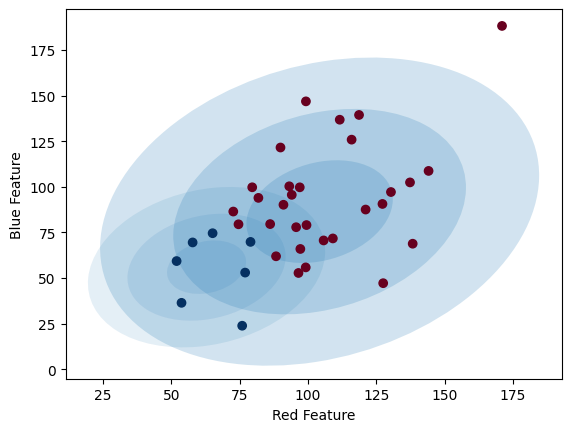

In [24]:
y_pred = gmm.predict(X_test.values)

plt.scatter(X_test['Red'], X_test['Blue'], c=y_pred,cmap='RdBu_r', zorder=2)
w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
  draw_ellipse(pos, covar, alpha=w * w_factor)
plt.xlabel('Red Feature')
plt.ylabel('Blue Feature')
plt.show()

## Best n_components

In [25]:
n_components = range(1, 11)
aic_scores = []
bic_scores = []
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=123)
    gmm.fit(X_train)
    aic_scores.append(gmm.aic(X_test))
    bic_scores.append(gmm.bic(X_test))

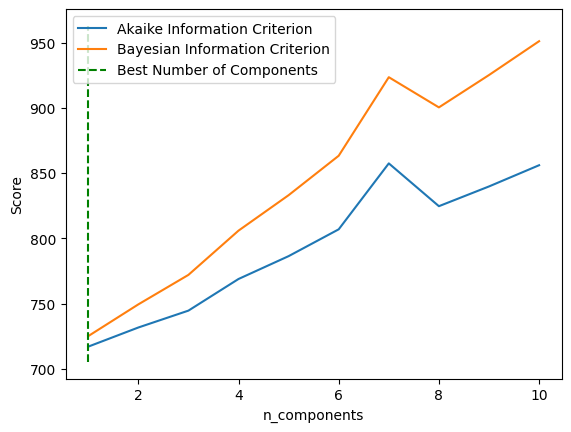

In [26]:
plt.plot(n_components, aic_scores, label='Akaike Information Criterion')
plt.plot(n_components, bic_scores, label='Bayesian Information Criterion')
best_n_components = n_components[aic_scores.index(min(aic_scores))]
plt.vlines(best_n_components, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',label='Best Number of Components',colors='g')
plt.xlabel('n_components')
plt.ylabel('Score')
plt.legend()
plt.show()